In [1]:
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm
import torch
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from visualize import visualize_dataset
from causal_inference import compute_ATE, ATE
from dataset import DatasetCausalInference, ObservedDataset
from raw_embedding import RawEmbedding
from causal_embedding import DebiasedEmbeddingNet
from naive_embedding import NaiveEmbeddingNet
import config

In [2]:
# Set the seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### DATASET CONFIGURATION ###
num_seeds = config.num_seeds
dim_covariate = config.dim_covariate
dim_covariate_image = config.dim_covariate_image
dim_post_treatment = config.dim_post_treatment

### AUTOENCODER CONFIGURATION ###
data_root = "./data"
batch_size_autoencoder = config.batch_size_autoencoder

### CAUSAL INFERENCE CONFIGURATION ###
# Specify the sample size for the training and test dataset
trainig_sample_size = config.trainig_sample_size
test_sample_size = config.test_sample_size

# Define the batch size for causal inference
batch_size_causal_embedding = config.batch_size_causal_embedding

# Define the learning rate, number of epochs, and weight decay for the embedding net
lr_embed = config.lr_embed
epochs_embed = config.epochs_embed
weight_decay_embed = config.weight_decay_embed

# Define the dimension of the embedding of the image covariate and post-treatment
dim_covariate_image_embed = config.dim_covariate_image_embed
dim_post_treatment_embed = config.dim_post_treatment_embed

dim_covariate_image_embed_naive = config.dim_covariate_image_embed_naive

In [5]:
# Define the dataframe for storing the results
df_result = pd.DataFrame(columns=["id", "estimator", "method", "train_err", "test_err"])

In [6]:
tfm = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(data_root, train=True , download=True, transform=tfm)
test_dataset  = datasets.FashionMNIST(data_root, train=False, download=True, transform=tfm)

train_dataset_no_transform = datasets.FashionMNIST(data_root, train=True , download=True)
test_dataset_no_transform  = datasets.FashionMNIST(data_root, train=False, download=True)

train_dataset = Subset(train_dataset, range(config.n_train_fMNIST))
test_dataset  = Subset(test_dataset,  range(config.n_test_fMNIST))

In [7]:
# Create data loader for obtaining embedding of the raw images
train_loader = DataLoader(train_dataset, batch_size=batch_size_autoencoder, shuffle=False)
test_loader  = DataLoader(test_dataset , batch_size=batch_size_autoencoder, shuffle=False)

raw_embedding = RawEmbedding(hidden_dim=dim_covariate_image, train_loader=train_loader, test_loader=test_loader)
train_embeddings, test_embeddings = raw_embedding.obtain_embeddings()

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


In [8]:
train_embeddings.shape

torch.Size([1000, 10])

In [9]:
# Save and load the embeddings
torch.save((train_embeddings, test_embeddings), "fashion_mnist_embedding.pt") # Save the embeddings
train_embeddings, test_embeddings = torch.load("fashion_mnist_embedding.pt") # Load the saved embeddings

In [10]:
# Create the dataset object for causal inference
dataset_ci = DatasetCausalInference(dim_covariate, dim_covariate_image, dim_post_treatment, train_embeddings, test_embeddings, train_dataset_no_transform, test_dataset_no_transform)

  0%|          | 0/10 [00:00<?, ?it/s]

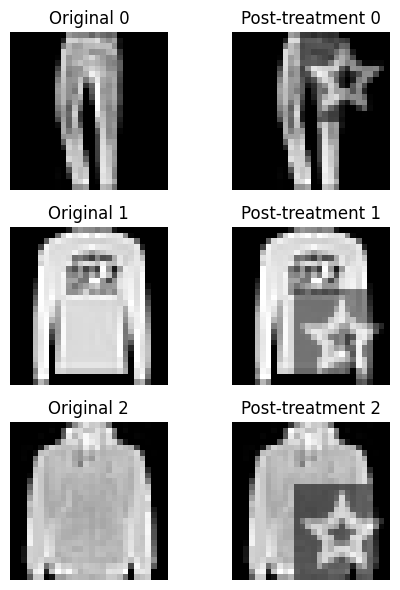

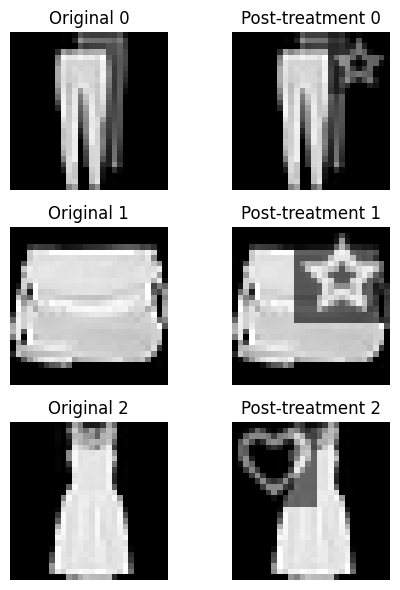


Seed 0 / 10:  10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Epoch 1/10 Loss: 0.1313



Seed 0 / 10:  20%|██        | 2/10 [00:10<00:42,  5.35s/it]

Epoch 2/10 Loss: 0.0772



Seed 0 / 10:  30%|███       | 3/10 [00:16<00:39,  5.59s/it]

Epoch 3/10 Loss: 0.0636



Seed 0 / 10:  40%|████      | 4/10 [00:21<00:32,  5.34s/it]

Epoch 4/10 Loss: 0.0516



Seed 0 / 10:  50%|█████     | 5/10 [00:27<00:27,  5.43s/it]

Epoch 5/10 Loss: 0.0403



Seed 0 / 10:  60%|██████    | 6/10 [00:32<00:21,  5.33s/it]

Epoch 6/10 Loss: 0.0337



Seed 0 / 10:  70%|███████   | 7/10 [00:37<00:15,  5.22s/it]

Epoch 7/10 Loss: 0.0304



Seed 0 / 10:  80%|████████  | 8/10 [00:43<00:10,  5.39s/it]

Epoch 8/10 Loss: 0.0283



Seed 0 / 10:  90%|█████████ | 9/10 [00:48<00:05,  5.25s/it]

Epoch 9/10 Loss: 0.0264



Seed 0 / 10: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


Epoch 10/10 Loss: 0.0248



 10%|█         | 1/10 [00:06<00:56,  6.23s/it]

Epoch 1/10 Loss: 0.8704



 20%|██        | 2/10 [00:13<00:53,  6.63s/it]

Epoch 2/10 Loss: 0.4682



 30%|███       | 3/10 [00:19<00:45,  6.44s/it]

Epoch 3/10 Loss: 0.3439



 40%|████      | 4/10 [00:26<00:39,  6.64s/it]

Epoch 4/10 Loss: 0.2817



 50%|█████     | 5/10 [00:32<00:32,  6.43s/it]

Epoch 5/10 Loss: 0.2420



 60%|██████    | 6/10 [00:40<00:27,  6.97s/it]

Epoch 6/10 Loss: 0.2153



 70%|███████   | 7/10 [00:46<00:20,  6.69s/it]

Epoch 7/10 Loss: 0.1876



 80%|████████  | 8/10 [00:53<00:13,  6.74s/it]

Epoch 8/10 Loss: 0.1630



 90%|█████████ | 9/10 [00:59<00:06,  6.66s/it]

Epoch 9/10 Loss: 0.1514



100%|██████████| 10/10 [01:06<00:00,  6.65s/it]

Epoch 10/10 Loss: 0.1351



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err      test_err
0   0  regression    biased   0.000930  8.053387e-04
1   0         ipw    biased   0.000940  8.110957e-04
2   0          dr    biased   0.000934  8.073875e-04
3   0  regression     naive   0.000938  3.394064e-04
4   0         ipw     naive   0.001010  3.347583e-03
5   0          dr     naive   0.000947  9.708225e-04
6   0  regression  debiased   0.000950  1.434035e-07
7   0         ipw  debiased   0.000957  2.071013e-06
8   0          dr  debiased   0.000965  7.183886e-05


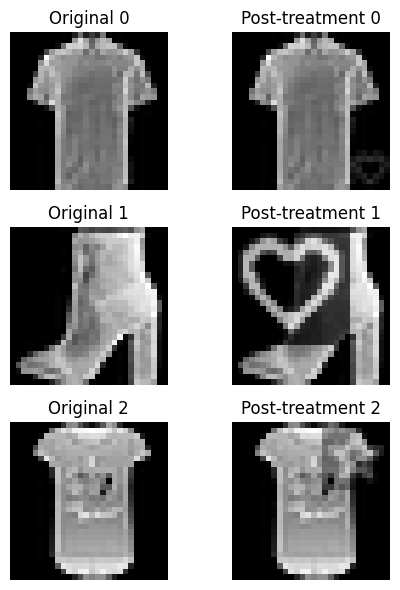

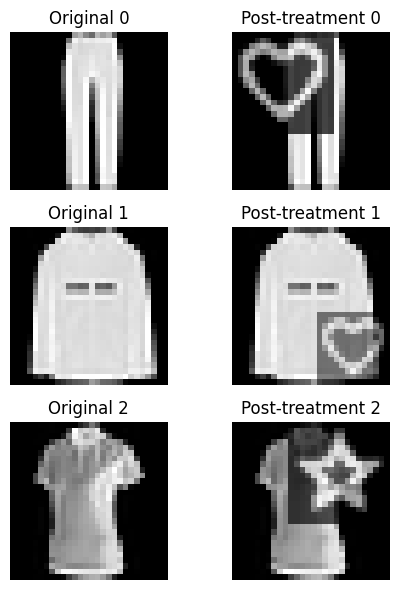


Seed 1 / 10:  10%|█         | 1/10 [00:04<00:43,  4.79s/it]

Epoch 1/10 Loss: 0.1068



Seed 1 / 10:  20%|██        | 2/10 [00:10<00:42,  5.29s/it]

Epoch 2/10 Loss: 0.0752



Seed 1 / 10:  30%|███       | 3/10 [00:15<00:35,  5.08s/it]

Epoch 3/10 Loss: 0.0534



Seed 1 / 10:  40%|████      | 4/10 [00:20<00:31,  5.32s/it]

Epoch 4/10 Loss: 0.0388



Seed 1 / 10:  50%|█████     | 5/10 [00:25<00:26,  5.22s/it]

Epoch 5/10 Loss: 0.0322



Seed 1 / 10:  60%|██████    | 6/10 [00:30<00:20,  5.09s/it]

Epoch 6/10 Loss: 0.0287



Seed 1 / 10:  70%|███████   | 7/10 [00:36<00:15,  5.28s/it]

Epoch 7/10 Loss: 0.0261



Seed 1 / 10:  80%|████████  | 8/10 [00:41<00:10,  5.16s/it]

Epoch 8/10 Loss: 0.0240



Seed 1 / 10:  90%|█████████ | 9/10 [00:47<00:05,  5.32s/it]

Epoch 9/10 Loss: 0.0224



Seed 1 / 10: 100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


Epoch 10/10 Loss: 0.0209



 10%|█         | 1/10 [00:07<01:03,  7.01s/it]

Epoch 1/10 Loss: 0.8489



 20%|██        | 2/10 [00:13<00:53,  6.71s/it]

Epoch 2/10 Loss: 0.4376



 30%|███       | 3/10 [00:20<00:48,  6.86s/it]

Epoch 3/10 Loss: 0.3153



 40%|████      | 4/10 [00:26<00:39,  6.63s/it]

Epoch 4/10 Loss: 0.2650



 50%|█████     | 5/10 [00:33<00:34,  6.81s/it]

Epoch 5/10 Loss: 0.2301



 60%|██████    | 6/10 [00:40<00:26,  6.61s/it]

Epoch 6/10 Loss: 0.1997



 70%|███████   | 7/10 [00:47<00:20,  6.80s/it]

Epoch 7/10 Loss: 0.1795



 80%|████████  | 8/10 [00:53<00:13,  6.61s/it]

Epoch 8/10 Loss: 0.1565



 90%|█████████ | 9/10 [01:00<00:06,  6.74s/it]

Epoch 9/10 Loss: 0.1413



100%|██████████| 10/10 [01:07<00:00,  6.70s/it]

Epoch 10/10 Loss: 0.1225



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   1  regression    biased   0.000188  0.001004
1   1         ipw    biased   0.000204  0.001032
2   1          dr    biased   0.000208  0.001018
3   1  regression     naive   0.000159  0.000075
4   1         ipw     naive   0.000174  0.008827
5   1          dr     naive   0.000177  0.000019
6   1  regression  debiased   0.000179  0.000003
7   1         ipw  debiased   0.000194  0.000008
8   1          dr  debiased   0.000193  0.000063


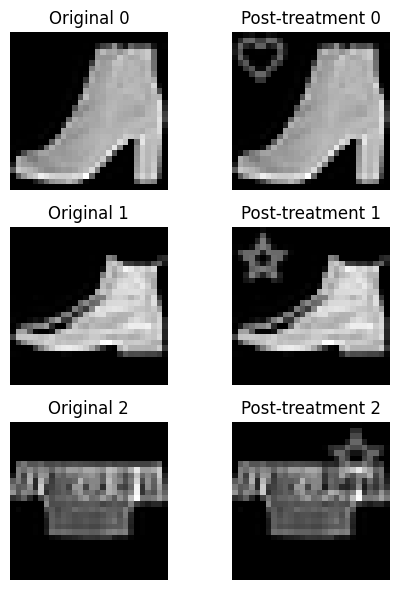

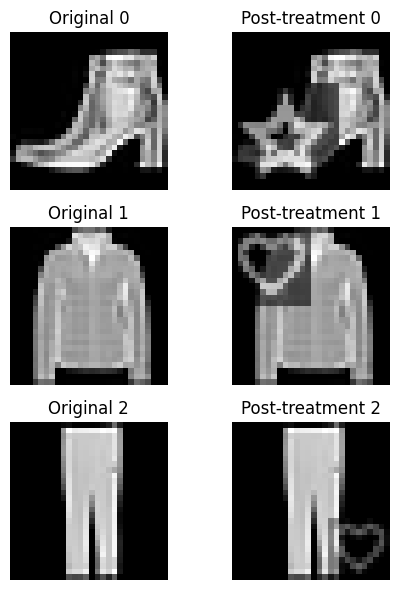


Seed 2 / 10:  10%|█         | 1/10 [00:05<00:49,  5.48s/it]

Epoch 1/10 Loss: 0.1332



Seed 2 / 10:  20%|██        | 2/10 [00:10<00:39,  4.98s/it]

Epoch 2/10 Loss: 0.0746



Seed 2 / 10:  30%|███       | 3/10 [00:15<00:35,  5.13s/it]

Epoch 3/10 Loss: 0.0634



Seed 2 / 10:  40%|████      | 4/10 [00:21<00:32,  5.48s/it]

Epoch 4/10 Loss: 0.0524



Seed 2 / 10:  50%|█████     | 5/10 [00:26<00:27,  5.49s/it]

Epoch 5/10 Loss: 0.0418



Seed 2 / 10:  60%|██████    | 6/10 [00:32<00:21,  5.45s/it]

Epoch 6/10 Loss: 0.0341



Seed 2 / 10:  70%|███████   | 7/10 [00:37<00:15,  5.21s/it]

Epoch 7/10 Loss: 0.0306



Seed 2 / 10:  80%|████████  | 8/10 [00:42<00:10,  5.33s/it]

Epoch 8/10 Loss: 0.0280



Seed 2 / 10:  90%|█████████ | 9/10 [00:47<00:05,  5.14s/it]

Epoch 9/10 Loss: 0.0258



Seed 2 / 10: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Epoch 10/10 Loss: 0.0241



 10%|█         | 1/10 [00:06<01:02,  6.89s/it]

Epoch 1/10 Loss: 0.8979



 20%|██        | 2/10 [00:13<00:55,  6.97s/it]

Epoch 2/10 Loss: 0.4862



 30%|███       | 3/10 [00:20<00:46,  6.71s/it]

Epoch 3/10 Loss: 0.3492



 40%|████      | 4/10 [00:27<00:41,  6.87s/it]

Epoch 4/10 Loss: 0.2779



 50%|█████     | 5/10 [00:33<00:33,  6.70s/it]

Epoch 5/10 Loss: 0.2448



 60%|██████    | 6/10 [00:40<00:27,  6.84s/it]

Epoch 6/10 Loss: 0.2159



 70%|███████   | 7/10 [00:47<00:19,  6.67s/it]

Epoch 7/10 Loss: 0.1910



 80%|████████  | 8/10 [00:54<00:13,  6.82s/it]

Epoch 8/10 Loss: 0.1660



 90%|█████████ | 9/10 [01:00<00:06,  6.66s/it]

Epoch 9/10 Loss: 0.1464



100%|██████████| 10/10 [01:07<00:00,  6.79s/it]

Epoch 10/10 Loss: 0.1302



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method     train_err      test_err
0   2  regression    biased  2.184622e-07  1.102731e-03
1   2         ipw    biased  1.854955e-06  1.092882e-03
2   2          dr    biased  1.059811e-06  1.089243e-03
3   2  regression     naive  2.601279e-08  7.305163e-05
4   2         ipw     naive  5.227887e-07  1.988482e-03
5   2          dr     naive  5.804850e-08  1.341132e-05
6   2  regression  debiased  3.552464e-09  2.356636e-06
7   2         ipw  debiased  8.920497e-07  1.248800e-03
8   2          dr  debiased  4.300593e-07  5.451032e-07


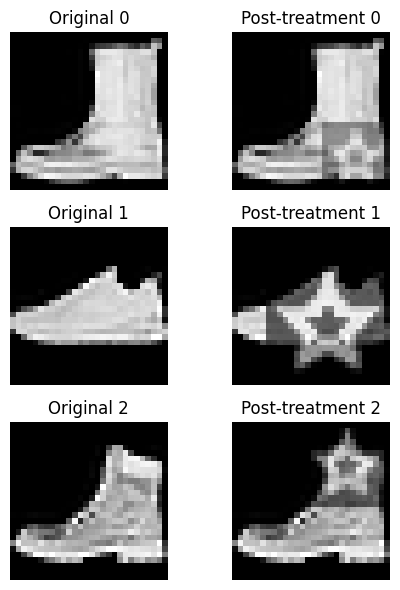

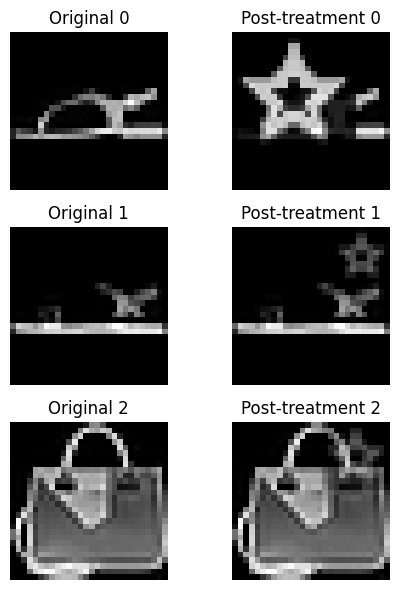


Seed 3 / 10:  10%|█         | 1/10 [00:04<00:43,  4.85s/it]

Epoch 1/10 Loss: 0.1223



Seed 3 / 10:  20%|██        | 2/10 [00:10<00:42,  5.32s/it]

Epoch 2/10 Loss: 0.0756



Seed 3 / 10:  30%|███       | 3/10 [00:15<00:35,  5.11s/it]

Epoch 3/10 Loss: 0.0609



Seed 3 / 10:  40%|████      | 4/10 [00:20<00:30,  5.11s/it]

Epoch 4/10 Loss: 0.0451



Seed 3 / 10:  50%|█████     | 5/10 [00:25<00:26,  5.24s/it]

Epoch 5/10 Loss: 0.0354



Seed 3 / 10:  60%|██████    | 6/10 [00:30<00:20,  5.12s/it]

Epoch 6/10 Loss: 0.0312



Seed 3 / 10:  70%|███████   | 7/10 [00:36<00:16,  5.34s/it]

Epoch 7/10 Loss: 0.0284



Seed 3 / 10:  80%|████████  | 8/10 [00:41<00:10,  5.18s/it]

Epoch 8/10 Loss: 0.0261



Seed 3 / 10:  90%|█████████ | 9/10 [00:46<00:05,  5.22s/it]

Epoch 9/10 Loss: 0.0242



Seed 3 / 10: 100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


Epoch 10/10 Loss: 0.0228



 10%|█         | 1/10 [00:06<00:59,  6.65s/it]

Epoch 1/10 Loss: 0.9616



 20%|██        | 2/10 [00:13<00:54,  6.84s/it]

Epoch 2/10 Loss: 0.5038



 30%|███       | 3/10 [00:21<00:50,  7.19s/it]

Epoch 3/10 Loss: 0.3464



 40%|████      | 4/10 [00:27<00:40,  6.82s/it]

Epoch 4/10 Loss: 0.2717



 50%|█████     | 5/10 [00:34<00:34,  6.92s/it]

Epoch 5/10 Loss: 0.2286



 60%|██████    | 6/10 [00:40<00:26,  6.74s/it]

Epoch 6/10 Loss: 0.1991



 70%|███████   | 7/10 [00:48<00:20,  6.88s/it]

Epoch 7/10 Loss: 0.1723



 80%|████████  | 8/10 [00:54<00:13,  6.75s/it]

Epoch 8/10 Loss: 0.1502



 90%|█████████ | 9/10 [01:01<00:06,  6.88s/it]

Epoch 9/10 Loss: 0.1394



100%|██████████| 10/10 [01:08<00:00,  6.82s/it]

Epoch 10/10 Loss: 0.1240



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   3  regression    biased   0.000022  0.000089
1   3         ipw    biased   0.000013  0.000099
2   3          dr    biased   0.000015  0.000094
3   3  regression     naive   0.000011  0.000153
4   3         ipw     naive   0.000008  0.004004
5   3          dr     naive   0.000007  0.000671
6   3  regression  debiased   0.000019  0.000004
7   3         ipw  debiased   0.000010  0.001678
8   3          dr  debiased   0.000011  0.000231


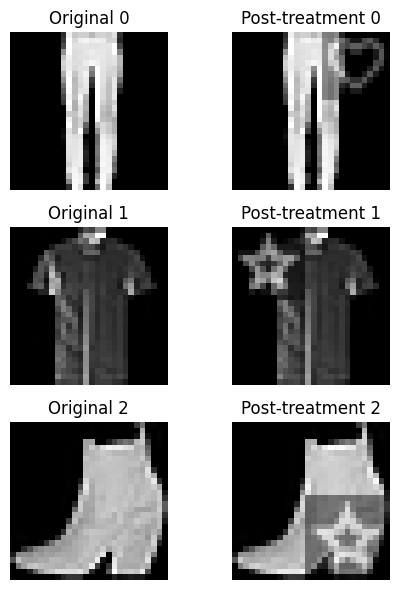

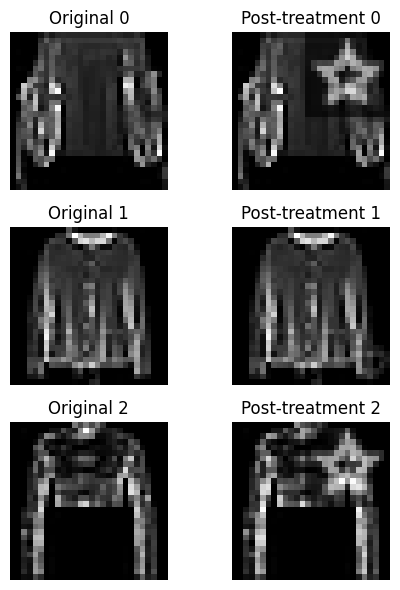


Seed 4 / 10:  10%|█         | 1/10 [00:05<00:50,  5.59s/it]

Epoch 1/10 Loss: 0.1279



Seed 4 / 10:  20%|██        | 2/10 [00:10<00:40,  5.07s/it]

Epoch 2/10 Loss: 0.0740



Seed 4 / 10:  30%|███       | 3/10 [00:15<00:36,  5.14s/it]

Epoch 3/10 Loss: 0.0591



Seed 4 / 10:  40%|████      | 4/10 [00:20<00:30,  5.16s/it]

Epoch 4/10 Loss: 0.0442



Seed 4 / 10:  50%|█████     | 5/10 [00:25<00:25,  5.05s/it]

Epoch 5/10 Loss: 0.0338



Seed 4 / 10:  60%|██████    | 6/10 [00:31<00:20,  5.22s/it]

Epoch 6/10 Loss: 0.0297



Seed 4 / 10:  70%|███████   | 7/10 [00:35<00:15,  5.09s/it]

Epoch 7/10 Loss: 0.0270



Seed 4 / 10:  80%|████████  | 8/10 [00:42<00:10,  5.49s/it]

Epoch 8/10 Loss: 0.0249



Seed 4 / 10:  90%|█████████ | 9/10 [00:47<00:05,  5.26s/it]

Epoch 9/10 Loss: 0.0232



Seed 4 / 10: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


Epoch 10/10 Loss: 0.0220



 10%|█         | 1/10 [00:07<01:03,  7.11s/it]

Epoch 1/10 Loss: 0.8995



 20%|██        | 2/10 [00:13<00:54,  6.83s/it]

Epoch 2/10 Loss: 0.4893



 30%|███       | 3/10 [00:20<00:47,  6.77s/it]

Epoch 3/10 Loss: 0.3506



 40%|████      | 4/10 [00:27<00:41,  6.87s/it]

Epoch 4/10 Loss: 0.2838



 50%|█████     | 5/10 [00:33<00:33,  6.69s/it]

Epoch 5/10 Loss: 0.2433



 60%|██████    | 6/10 [00:40<00:27,  6.82s/it]

Epoch 6/10 Loss: 0.2178



 70%|███████   | 7/10 [00:47<00:19,  6.66s/it]

Epoch 7/10 Loss: 0.1920



 80%|████████  | 8/10 [00:54<00:13,  6.78s/it]

Epoch 8/10 Loss: 0.1684



 90%|█████████ | 9/10 [01:00<00:06,  6.61s/it]

Epoch 9/10 Loss: 0.1490



100%|██████████| 10/10 [01:07<00:00,  6.76s/it]

Epoch 10/10 Loss: 0.1320



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   4  regression    biased   0.001489  0.001417
1   4         ipw    biased   0.001491  0.001429
2   4          dr    biased   0.001489  0.001420
3   4  regression     naive   0.001511  0.000318
4   4         ipw     naive   0.001514  0.005749
5   4          dr     naive   0.001516  0.000560
6   4  regression  debiased   0.001478  0.000001
7   4         ipw  debiased   0.001481  0.000067
8   4          dr  debiased   0.001475  0.000065


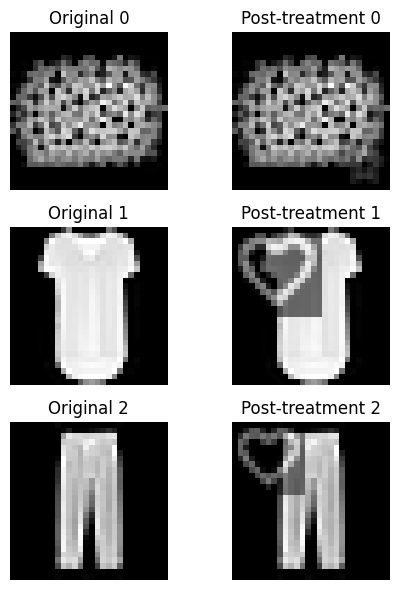

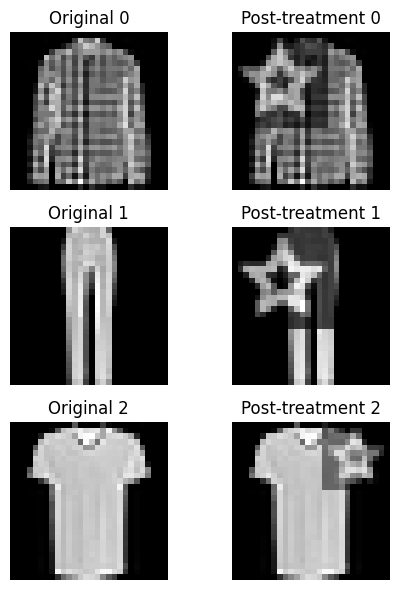


Seed 5 / 10:  10%|█         | 1/10 [00:05<00:45,  5.00s/it]

Epoch 1/10 Loss: 0.1143



Seed 5 / 10:  20%|██        | 2/10 [00:10<00:43,  5.43s/it]

Epoch 2/10 Loss: 0.0749



Seed 5 / 10:  30%|███       | 3/10 [00:15<00:37,  5.35s/it]

Epoch 3/10 Loss: 0.0571



Seed 5 / 10:  40%|████      | 4/10 [00:21<00:31,  5.25s/it]

Epoch 4/10 Loss: 0.0409



Seed 5 / 10:  50%|█████     | 5/10 [00:26<00:27,  5.49s/it]

Epoch 5/10 Loss: 0.0324



Seed 5 / 10:  60%|██████    | 6/10 [00:32<00:21,  5.36s/it]

Epoch 6/10 Loss: 0.0288



Seed 5 / 10:  70%|███████   | 7/10 [00:38<00:16,  5.54s/it]

Epoch 7/10 Loss: 0.0261



Seed 5 / 10:  80%|████████  | 8/10 [00:43<00:10,  5.41s/it]

Epoch 8/10 Loss: 0.0239



Seed 5 / 10:  90%|█████████ | 9/10 [00:49<00:05,  5.55s/it]

Epoch 9/10 Loss: 0.0223



Seed 5 / 10: 100%|██████████| 10/10 [00:54<00:00,  5.41s/it]


Epoch 10/10 Loss: 0.0210



 10%|█         | 1/10 [00:07<01:04,  7.15s/it]

Epoch 1/10 Loss: 0.9237



 20%|██        | 2/10 [00:13<00:53,  6.72s/it]

Epoch 2/10 Loss: 0.4642



 30%|███       | 3/10 [00:20<00:48,  6.97s/it]

Epoch 3/10 Loss: 0.3390



 40%|████      | 4/10 [00:27<00:40,  6.71s/it]

Epoch 4/10 Loss: 0.2856



 50%|█████     | 5/10 [00:34<00:34,  6.91s/it]

Epoch 5/10 Loss: 0.2482



 60%|██████    | 6/10 [00:40<00:27,  6.75s/it]

Epoch 6/10 Loss: 0.2220



 70%|███████   | 7/10 [00:48<00:20,  6.89s/it]

Epoch 7/10 Loss: 0.2013



 80%|████████  | 8/10 [00:54<00:13,  6.73s/it]

Epoch 8/10 Loss: 0.1817



 90%|█████████ | 9/10 [01:01<00:06,  6.86s/it]

Epoch 9/10 Loss: 0.1522



100%|██████████| 10/10 [01:08<00:00,  6.80s/it]

Epoch 10/10 Loss: 0.1377



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err      test_err
0   5  regression    biased   0.001727  1.316893e-03
1   5         ipw    biased   0.001732  1.272933e-03
2   5          dr    biased   0.001723  1.274589e-03
3   5  regression     naive   0.001741  1.327741e-04
4   5         ipw     naive   0.001768  2.563981e-04
5   5          dr     naive   0.001753  8.538277e-05
6   5  regression  debiased   0.001746  6.469706e-05
7   5         ipw  debiased   0.001763  7.875463e-04
8   5          dr  debiased   0.001739  3.192721e-07


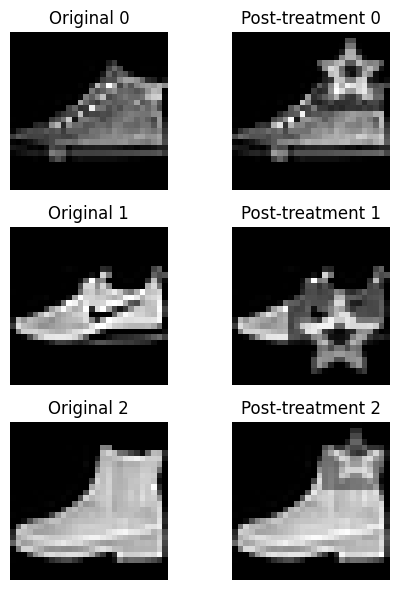

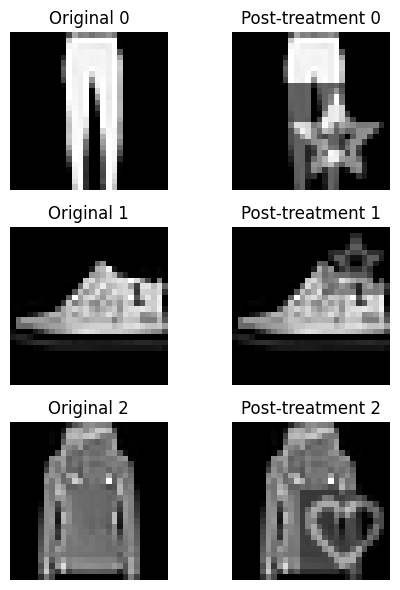


Seed 6 / 10:  10%|█         | 1/10 [00:05<00:52,  5.80s/it]

Epoch 1/10 Loss: 0.1026



Seed 6 / 10:  20%|██        | 2/10 [00:10<00:42,  5.29s/it]

Epoch 2/10 Loss: 0.0666



Seed 6 / 10:  30%|███       | 3/10 [00:16<00:38,  5.52s/it]

Epoch 3/10 Loss: 0.0430



Seed 6 / 10:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Epoch 4/10 Loss: 0.0336



Seed 6 / 10:  50%|█████     | 5/10 [00:26<00:26,  5.25s/it]

Epoch 5/10 Loss: 0.0294



Seed 6 / 10:  60%|██████    | 6/10 [00:32<00:21,  5.36s/it]

Epoch 6/10 Loss: 0.0262



Seed 6 / 10:  70%|███████   | 7/10 [00:37<00:15,  5.23s/it]

Epoch 7/10 Loss: 0.0241



Seed 6 / 10:  80%|████████  | 8/10 [00:42<00:10,  5.41s/it]

Epoch 8/10 Loss: 0.0225



Seed 6 / 10:  90%|█████████ | 9/10 [00:47<00:05,  5.27s/it]

Epoch 9/10 Loss: 0.0212



Seed 6 / 10: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


Epoch 10/10 Loss: 0.0200



 10%|█         | 1/10 [00:06<00:56,  6.27s/it]

Epoch 1/10 Loss: 0.9476



 20%|██        | 2/10 [00:13<00:54,  6.77s/it]

Epoch 2/10 Loss: 0.4716



 30%|███       | 3/10 [00:19<00:46,  6.57s/it]

Epoch 3/10 Loss: 0.3230



 40%|████      | 4/10 [00:26<00:40,  6.77s/it]

Epoch 4/10 Loss: 0.2650



 50%|█████     | 5/10 [00:33<00:33,  6.63s/it]

Epoch 5/10 Loss: 0.2215



 60%|██████    | 6/10 [00:40<00:27,  6.76s/it]

Epoch 6/10 Loss: 0.1960



 70%|███████   | 7/10 [00:46<00:19,  6.60s/it]

Epoch 7/10 Loss: 0.1791



 80%|████████  | 8/10 [00:53<00:13,  6.76s/it]

Epoch 8/10 Loss: 0.1638



 90%|█████████ | 9/10 [00:59<00:06,  6.60s/it]

Epoch 9/10 Loss: 0.1451



100%|██████████| 10/10 [01:06<00:00,  6.69s/it]

Epoch 10/10 Loss: 0.1291



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err      test_err
0   6  regression    biased   0.000512  1.120864e-03
1   6         ipw    biased   0.000514  1.159550e-03
2   6          dr    biased   0.000505  1.148900e-03
3   6  regression     naive   0.000512  1.008223e-04
4   6         ipw     naive   0.000490  6.937318e-03
5   6          dr     naive   0.000498  7.249855e-04
6   6  regression  debiased   0.000542  4.888933e-04
7   6         ipw  debiased   0.000532  1.264909e-04
8   6          dr  debiased   0.000519  1.876977e-07


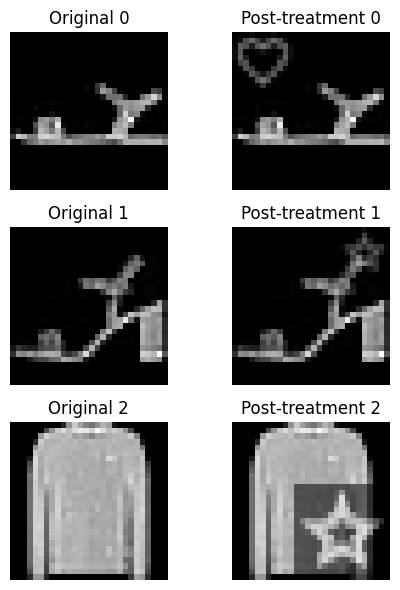

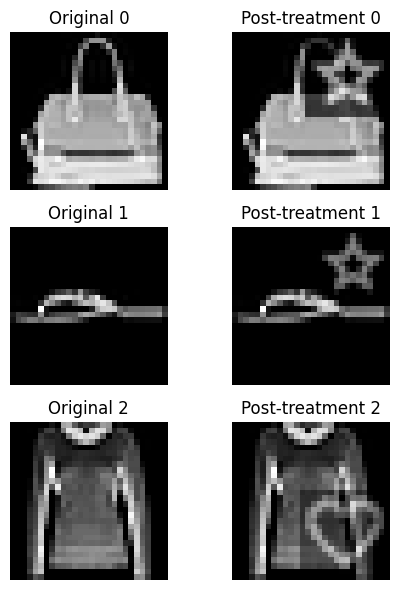


Seed 7 / 10:  10%|█         | 1/10 [00:04<00:44,  4.99s/it]

Epoch 1/10 Loss: 0.1298



Seed 7 / 10:  20%|██        | 2/10 [00:10<00:43,  5.44s/it]

Epoch 2/10 Loss: 0.0766



Seed 7 / 10:  30%|███       | 3/10 [00:15<00:36,  5.24s/it]

Epoch 3/10 Loss: 0.0641



Seed 7 / 10:  40%|████      | 4/10 [00:21<00:32,  5.43s/it]

Epoch 4/10 Loss: 0.0502



Seed 7 / 10:  50%|█████     | 5/10 [00:26<00:26,  5.26s/it]

Epoch 5/10 Loss: 0.0386



Seed 7 / 10:  60%|██████    | 6/10 [00:31<00:20,  5.14s/it]

Epoch 6/10 Loss: 0.0324



Seed 7 / 10:  70%|███████   | 7/10 [00:37<00:16,  5.47s/it]

Epoch 7/10 Loss: 0.0291



Seed 7 / 10:  80%|████████  | 8/10 [00:42<00:10,  5.32s/it]

Epoch 8/10 Loss: 0.0265



Seed 7 / 10:  90%|█████████ | 9/10 [00:48<00:05,  5.49s/it]

Epoch 9/10 Loss: 0.0245



Seed 7 / 10: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


Epoch 10/10 Loss: 0.0229



 10%|█         | 1/10 [00:07<01:05,  7.23s/it]

Epoch 1/10 Loss: 0.9359



 20%|██        | 2/10 [00:13<00:53,  6.63s/it]

Epoch 2/10 Loss: 0.5349



 30%|███       | 3/10 [00:20<00:48,  6.86s/it]

Epoch 3/10 Loss: 0.3642



 40%|████      | 4/10 [00:26<00:39,  6.66s/it]

Epoch 4/10 Loss: 0.2928



 50%|█████     | 5/10 [00:34<00:34,  6.83s/it]

Epoch 5/10 Loss: 0.2460



 60%|██████    | 6/10 [00:40<00:26,  6.66s/it]

Epoch 6/10 Loss: 0.2193



 70%|███████   | 7/10 [00:47<00:20,  6.82s/it]

Epoch 7/10 Loss: 0.2004



 80%|████████  | 8/10 [00:54<00:13,  6.73s/it]

Epoch 8/10 Loss: 0.1832



 90%|█████████ | 9/10 [01:01<00:06,  6.81s/it]

Epoch 9/10 Loss: 0.1603



100%|██████████| 10/10 [01:07<00:00,  6.79s/it]

Epoch 10/10 Loss: 0.1505



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   7  regression    biased   0.000997  0.000082
1   7         ipw    biased   0.000947  0.000079
2   7          dr    biased   0.000936  0.000074
3   7  regression     naive   0.000940  0.000097
4   7         ipw     naive   0.000857  0.002114
5   7          dr     naive   0.000869  0.000019
6   7  regression  debiased   0.001029  0.000014
7   7         ipw  debiased   0.000962  0.004748
8   7          dr  debiased   0.000960  0.000061


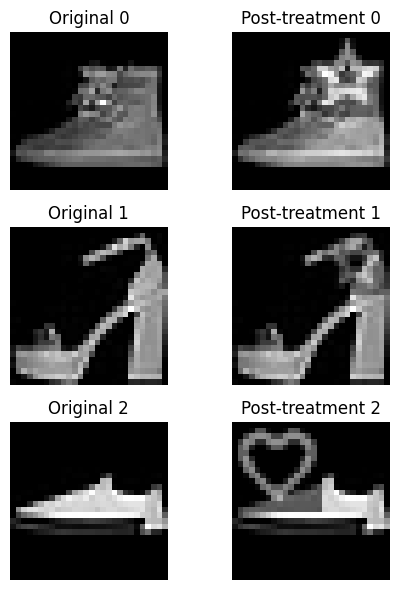

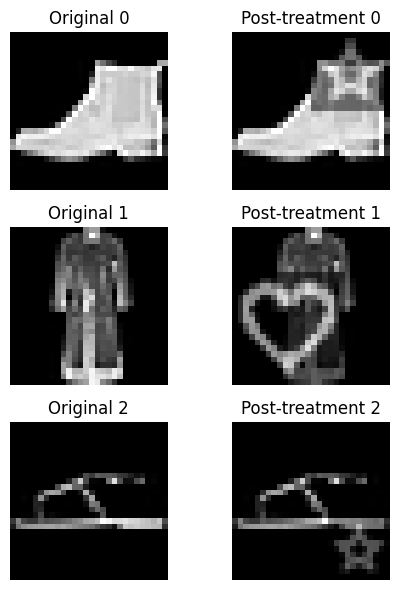


Seed 8 / 10:  10%|█         | 1/10 [00:05<00:51,  5.76s/it]

Epoch 1/10 Loss: 0.1327



Seed 8 / 10:  20%|██        | 2/10 [00:10<00:42,  5.30s/it]

Epoch 2/10 Loss: 0.0765



Seed 8 / 10:  30%|███       | 3/10 [00:16<00:38,  5.51s/it]

Epoch 3/10 Loss: 0.0648



Seed 8 / 10:  40%|████      | 4/10 [00:21<00:31,  5.32s/it]

Epoch 4/10 Loss: 0.0512



Seed 8 / 10:  50%|█████     | 5/10 [00:27<00:27,  5.41s/it]

Epoch 5/10 Loss: 0.0388



Seed 8 / 10:  60%|██████    | 6/10 [00:32<00:21,  5.33s/it]

Epoch 6/10 Loss: 0.0327



Seed 8 / 10:  70%|███████   | 7/10 [00:37<00:15,  5.21s/it]

Epoch 7/10 Loss: 0.0295



Seed 8 / 10:  80%|████████  | 8/10 [00:42<00:10,  5.38s/it]

Epoch 8/10 Loss: 0.0271



Seed 8 / 10:  90%|█████████ | 9/10 [00:47<00:05,  5.26s/it]

Epoch 9/10 Loss: 0.0251



Seed 8 / 10: 100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Epoch 10/10 Loss: 0.0237



 10%|█         | 1/10 [00:06<00:56,  6.30s/it]

Epoch 1/10 Loss: 0.9293



 20%|██        | 2/10 [00:13<00:54,  6.80s/it]

Epoch 2/10 Loss: 0.5146



 30%|███       | 3/10 [00:19<00:45,  6.56s/it]

Epoch 3/10 Loss: 0.3535



 40%|████      | 4/10 [00:26<00:40,  6.79s/it]

Epoch 4/10 Loss: 0.2848



 50%|█████     | 5/10 [00:33<00:32,  6.60s/it]

Epoch 5/10 Loss: 0.2396



 60%|██████    | 6/10 [00:40<00:26,  6.72s/it]

Epoch 6/10 Loss: 0.2079



 70%|███████   | 7/10 [00:46<00:19,  6.59s/it]

Epoch 7/10 Loss: 0.1804



 80%|████████  | 8/10 [00:53<00:13,  6.75s/it]

Epoch 8/10 Loss: 0.1584



 90%|█████████ | 9/10 [01:00<00:06,  6.69s/it]

Epoch 9/10 Loss: 0.1377



100%|██████████| 10/10 [01:06<00:00,  6.68s/it]

Epoch 10/10 Loss: 0.1217



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   8  regression    biased   0.000314  0.000038
1   8         ipw    biased   0.000326  0.000041
2   8          dr    biased   0.000331  0.000039
3   8  regression     naive   0.000303  0.000204
4   8         ipw     naive   0.000336  0.002758
5   8          dr     naive   0.000324  0.000348
6   8  regression  debiased   0.000277  0.004519
7   8         ipw  debiased   0.000262  0.001428
8   8          dr  debiased   0.000274  0.000085


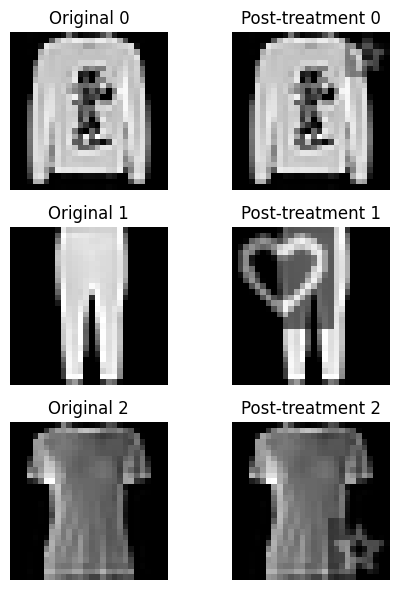

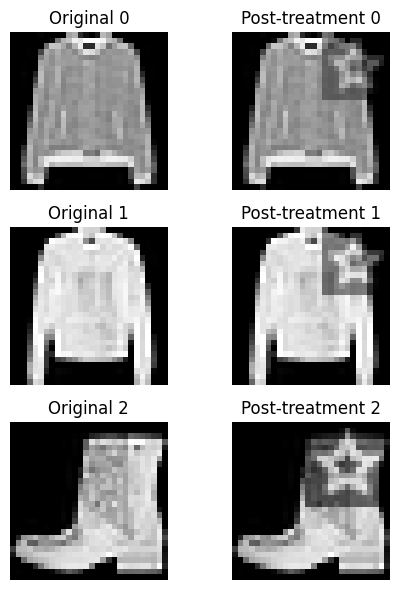


Seed 9 / 10:  10%|█         | 1/10 [00:04<00:43,  4.79s/it]

Epoch 1/10 Loss: 0.1107



Seed 9 / 10:  20%|██        | 2/10 [00:10<00:42,  5.28s/it]

Epoch 2/10 Loss: 0.0731



Seed 9 / 10:  30%|███       | 3/10 [00:15<00:35,  5.06s/it]

Epoch 3/10 Loss: 0.0584



Seed 9 / 10:  40%|████      | 4/10 [00:20<00:31,  5.21s/it]

Epoch 4/10 Loss: 0.0432



Seed 9 / 10:  50%|█████     | 5/10 [00:25<00:25,  5.14s/it]

Epoch 5/10 Loss: 0.0342



Seed 9 / 10:  60%|██████    | 6/10 [00:30<00:20,  5.04s/it]

Epoch 6/10 Loss: 0.0304



Seed 9 / 10:  70%|███████   | 7/10 [00:36<00:15,  5.21s/it]

Epoch 7/10 Loss: 0.0276



Seed 9 / 10:  80%|████████  | 8/10 [00:40<00:10,  5.08s/it]

Epoch 8/10 Loss: 0.0253



Seed 9 / 10:  90%|█████████ | 9/10 [00:46<00:05,  5.22s/it]

Epoch 9/10 Loss: 0.0234



Seed 9 / 10: 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Epoch 10/10 Loss: 0.0220



 10%|█         | 1/10 [00:06<01:02,  6.96s/it]

Epoch 1/10 Loss: 0.9661



 20%|██        | 2/10 [00:13<00:53,  6.66s/it]

Epoch 2/10 Loss: 0.5221



 30%|███       | 3/10 [00:20<00:47,  6.86s/it]

Epoch 3/10 Loss: 0.3548



 40%|████      | 4/10 [00:26<00:39,  6.64s/it]

Epoch 4/10 Loss: 0.2851



 50%|█████     | 5/10 [00:33<00:34,  6.81s/it]

Epoch 5/10 Loss: 0.2419



 60%|██████    | 6/10 [00:40<00:26,  6.64s/it]

Epoch 6/10 Loss: 0.2136



 70%|███████   | 7/10 [00:47<00:20,  6.82s/it]

Epoch 7/10 Loss: 0.1806



 80%|████████  | 8/10 [00:53<00:13,  6.64s/it]

Epoch 8/10 Loss: 0.1656



 90%|█████████ | 9/10 [01:00<00:06,  6.78s/it]

Epoch 9/10 Loss: 0.1452



100%|██████████| 10/10 [01:06<00:00,  6.70s/it]

Epoch 10/10 Loss: 0.1304



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _

   id   estimator    method  train_err  test_err
0   9  regression    biased   0.000395  0.000311
1   9         ipw    biased   0.000408  0.000340
2   9          dr    biased   0.000400  0.000330
3   9  regression     naive   0.000380  0.000358
4   9         ipw     naive   0.000393  0.003257
5   9          dr     naive   0.000386  0.000235
6   9  regression  debiased   0.000417  0.000636
7   9         ipw  debiased   0.000427  0.000529
8   9          dr  debiased   0.000418  0.000058


In [11]:
for seed in tqdm(range(num_seeds)):
    # Generate the training and test dataset for causal inference
    training_dataset_ci = dataset_ci.generate_dataset(trainig_sample_size, train = True)
    test_dataset_ci = dataset_ci.generate_dataset(test_sample_size, train = False)

    # Visualize the training and test dataset for causal inference 
    # Left: original FashionMNIST images
    # Right: image included in the dataset, which includes the post-treatment variables' components
    if config.display_image:
        visualize_dataset(training_dataset_ci, max_size=3)
        visualize_dataset(test_dataset_ci, max_size=3)

    # Create the observed dataset for causal inference
    observed_train_dataset_ci = ObservedDataset(training_dataset_ci["covariate"], training_dataset_ci["treatment"], training_dataset_ci["post_treatment_image_dataset"], training_dataset_ci["outcome"])
    observed_test_dataset_ci = ObservedDataset(test_dataset_ci["covariate"], test_dataset_ci["treatment"], test_dataset_ci["post_treatment_image_dataset"], test_dataset_ci["outcome"])

    # Create the data loader for causal inference
    train_loader_ci = DataLoader(observed_train_dataset_ci, batch_size=batch_size_causal_embedding, shuffle=True)
    test_loader_ci  = DataLoader(observed_test_dataset_ci , batch_size=batch_size_causal_embedding, shuffle=False)

    # Train the naive embedding net
    naive_embedding_net = NaiveEmbeddingNet(dim_covariate, dim_covariate_image_embed_naive, dim_post_treatment_embed)
    optimizer_naive_embed = torch.optim.Adam(naive_embedding_net.parameters(), lr=lr_embed, weight_decay=weight_decay_embed)
    mse_loss_naive = nn.MSELoss()

    for epoch in tqdm(range(epochs_embed), desc=f"Seed {seed} / {num_seeds}"):
        naive_embedding_net.train()
        loss_each_epoch = 0.0
        for batch in train_loader_ci:
            x, d, v, y = batch
            x_v, hat_v = naive_embedding_net(x, d, v, y)
            optimizer_naive_embed.zero_grad()
            loss_v = mse_loss_naive(hat_v, v)
            loss = loss_v
            loss.backward()
            optimizer_naive_embed.step()
            loss_each_epoch += loss.item() * x.size(0)
        if config.print_loss:
            print(f"Epoch {epoch+1}/{epochs_embed} Loss: {loss_each_epoch/len(train_loader_ci.dataset):.4f}")

    # Train the debiased embedding net
    debiased_embedding_net = DebiasedEmbeddingNet(dim_covariate, dim_covariate_image_embed, dim_post_treatment_embed)
    optimizer_embed = torch.optim.Adam(debiased_embedding_net.parameters(), lr=lr_embed, weight_decay=weight_decay_embed)
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()

    for epoch in tqdm(range(epochs_embed)):
        debiased_embedding_net.train()
        loss_each_epoch = 0.0
        for batch in train_loader_ci:
            x, d, v, y = batch
            x_v, p_v, hat_p_v, hat_d, hat_y, hat_v = debiased_embedding_net(x, d, v, y)
            optimizer_embed.zero_grad()
            loss_v = mse_loss(hat_v, v)
            loss_d = bce_loss(hat_d, d)
            loss_p = mse_loss(hat_p_v, p_v)
            loss_y = mse_loss(hat_y, y)
            loss = loss_v + loss_d + loss_p + loss_y
            loss.backward()
            optimizer_embed.step()
            loss_each_epoch += loss.item() * x.size(0)
        if config.print_loss:
            print(f"Epoch {epoch+1}/{epochs_embed} Loss: {loss_each_epoch/len(train_loader_ci.dataset):.4f}")


    # Define the function to compute the embeddings given a dataloader and a model
    def compute_embeddings(dataloader, model, dim_covariate_image_embed):
        model.eval()
        out = torch.zeros(len(dataloader.dataset), dim_covariate_image_embed, device=device)
        idx = 0
        for batch in dataloader:
            x, d, v, y = batch
            batch_size = x.size(0)
            with torch.no_grad():
                z = model.covariate_image_encoder(v.to(device))
            out[idx:idx+batch_size] = z
            idx += batch_size
        return out.cpu()

    # Compute the image embeddings of the training and test dataset for the naive embedding net
    naive_image_embeddings_train = compute_embeddings(train_loader_ci, naive_embedding_net, dim_covariate_image_embed_naive)
    naive_image_embeddings_test = compute_embeddings(test_loader_ci, naive_embedding_net, dim_covariate_image_embed_naive)

    # Compute the image embeddings of the training and test dataset for the debiased embedding net
    debiased_image_embeddings_train = compute_embeddings(train_loader_ci, debiased_embedding_net, dim_covariate_image_embed)
    debiased_image_embeddings_test = compute_embeddings(test_loader_ci, debiased_embedding_net, dim_covariate_image_embed)

    # Define the function to compute the true ATE and the estimators
    def compute_ground_truth_ATE_and_estimators(dataset, naive_image_embeddings, debiased_image_embeddings):
        # Compute the true ATE
        true_ATEs = compute_ATE(dataset, type = "true")
        true_ATE = true_ATEs.dr

        # Compute the biased ATE
        biased_ATEs = compute_ATE(dataset, type = "biased")

        # Compute the naive ATE
        naive_ATEs = compute_ATE(dataset, type = "learned_covariate_image", covariate_image = naive_image_embeddings)

        # Compute the debiased ATE
        debiased_ATEs = compute_ATE(dataset, type = "learned_covariate_image", covariate_image = debiased_image_embeddings)

        return ATE(true_ATE, biased_ATEs, naive_ATEs, debiased_ATEs)

    # Compute the true ATE and the estimates by each estimator and each method
    train_ATEs = compute_ground_truth_ATE_and_estimators(training_dataset_ci, naive_image_embeddings_train, debiased_image_embeddings_train)
    test_ATEs = compute_ground_truth_ATE_and_estimators(test_dataset_ci, naive_image_embeddings_test, debiased_image_embeddings_test)

    # Create a row to add to the dataframe
    new_rows = [{"id": seed, "estimator": "regression", "method": "biased", "train_err": train_ATEs.biased_ATE.error_reg(train_ATEs.true_ATE), "test_err": test_ATEs.biased_ATE.error_reg(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "ipw", "method": "biased", "train_err": train_ATEs.biased_ATE.error_ipw(train_ATEs.true_ATE), "test_err": test_ATEs.biased_ATE.error_ipw(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "dr", "method": "biased", "train_err": train_ATEs.biased_ATE.error_dr(train_ATEs.true_ATE), "test_err": test_ATEs.biased_ATE.error_dr(test_ATEs.true_ATE)},

                {"id": seed, "estimator": "regression", "method": "naive", "train_err": train_ATEs.naive_ATE.error_reg(train_ATEs.true_ATE), "test_err": test_ATEs.naive_ATE.error_reg(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "ipw", "method": "naive", "train_err": train_ATEs.naive_ATE.error_ipw(train_ATEs.true_ATE), "test_err": test_ATEs.naive_ATE.error_ipw(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "dr", "method": "naive", "train_err": train_ATEs.naive_ATE.error_dr(train_ATEs.true_ATE), "test_err": test_ATEs.naive_ATE.error_dr(test_ATEs.true_ATE)},

                {"id": seed, "estimator": "regression", "method": "debiased", "train_err": train_ATEs.debiased_ATE.error_reg(train_ATEs.true_ATE), "test_err": test_ATEs.debiased_ATE.error_reg(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "ipw", "method": "debiased", "train_err": train_ATEs.debiased_ATE.error_ipw(train_ATEs.true_ATE), "test_err": test_ATEs.debiased_ATE.error_ipw(test_ATEs.true_ATE)},
                {"id": seed, "estimator": "dr", "method": "debiased", "train_err": train_ATEs.debiased_ATE.error_dr(train_ATEs.true_ATE), "test_err": test_ATEs.debiased_ATE.error_dr(test_ATEs.true_ATE)},
                ]

    # Add the row to the dataframe
    df_new = pd.DataFrame(new_rows)
    if config.print_result_per_seed:
        print(df_new)
    df_result = pd.concat([df_result, df_new], ignore_index=True)

In [12]:
# Save the resulting dataframe
df_result.to_pickle("df_result.pkl")